([Text(0, 0.5, '')], None)

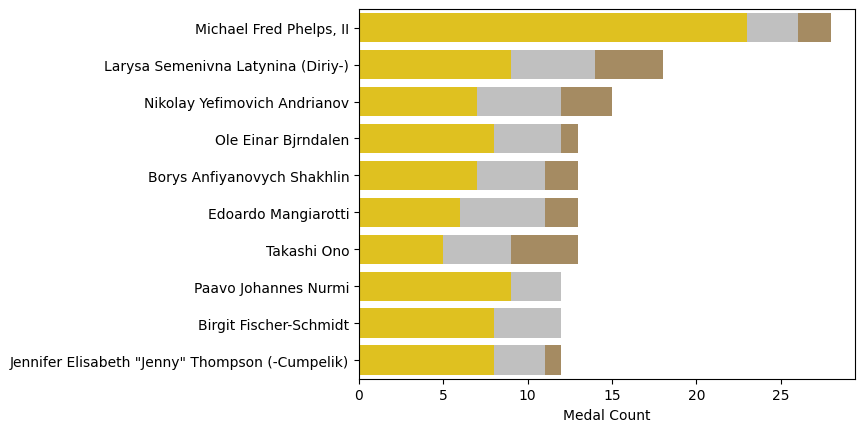

In [ ]:
############ Question 1 ############


import pandas as pd
import seaborn as sns

# lading csv file
df = pd.read_csv('olympic_athletes.csv')

#using previous codes for grouping, counting, sorting
athlete_medals = df.groupby('Name')['Medal'].value_counts().unstack(fill_value=0)
athlete_medals['Total'] = athlete_medals.sum(axis=1)
top_athletes = athlete_medals.sort_values(by=['Total','Gold','Silver','Bronze'], ascending=False).head(10)
top_athletes_ordered = top_athletes.sort_values(by=['Total','Gold','Silver','Bronze'], ascending=False)

#stacking for seaborn
top = top_athletes_ordered[['Gold','Silver','Bronze']].copy()
top['Name'] = top.index
top['Gold_medal']   = top['Gold']
top['Silver_medal'] = top['Gold'] + top['Silver']
top['Bronze_medal'] = top['Gold'] + top['Silver'] + top['Bronze']
df_melt = top.melt(id_vars='Name', value_vars=['Gold_medal','Silver_medal','Bronze_medal'],
                   var_name='Medal', value_name='Medal Count')
df_melt['Medal'] = df_melt['Medal'].map({'Gold_medal':'Gold', 'Silver_medal':'Silver', 'Bronze_medal':'Bronze'})

#seaborn code
(lambda ax: (ax.set(ylabel=''), ax.get_legend().remove()))(
    sns.barplot(x='Medal Count', y='Name', hue='Medal', data=df_melt, dodge=False,
                order=list(top_athletes.index),
                hue_order=['Bronze','Silver','Gold'],
                palette={'Gold':'#FFD700', 'Silver':'#C0C0C0', 'Bronze':'#B08D57'})
)

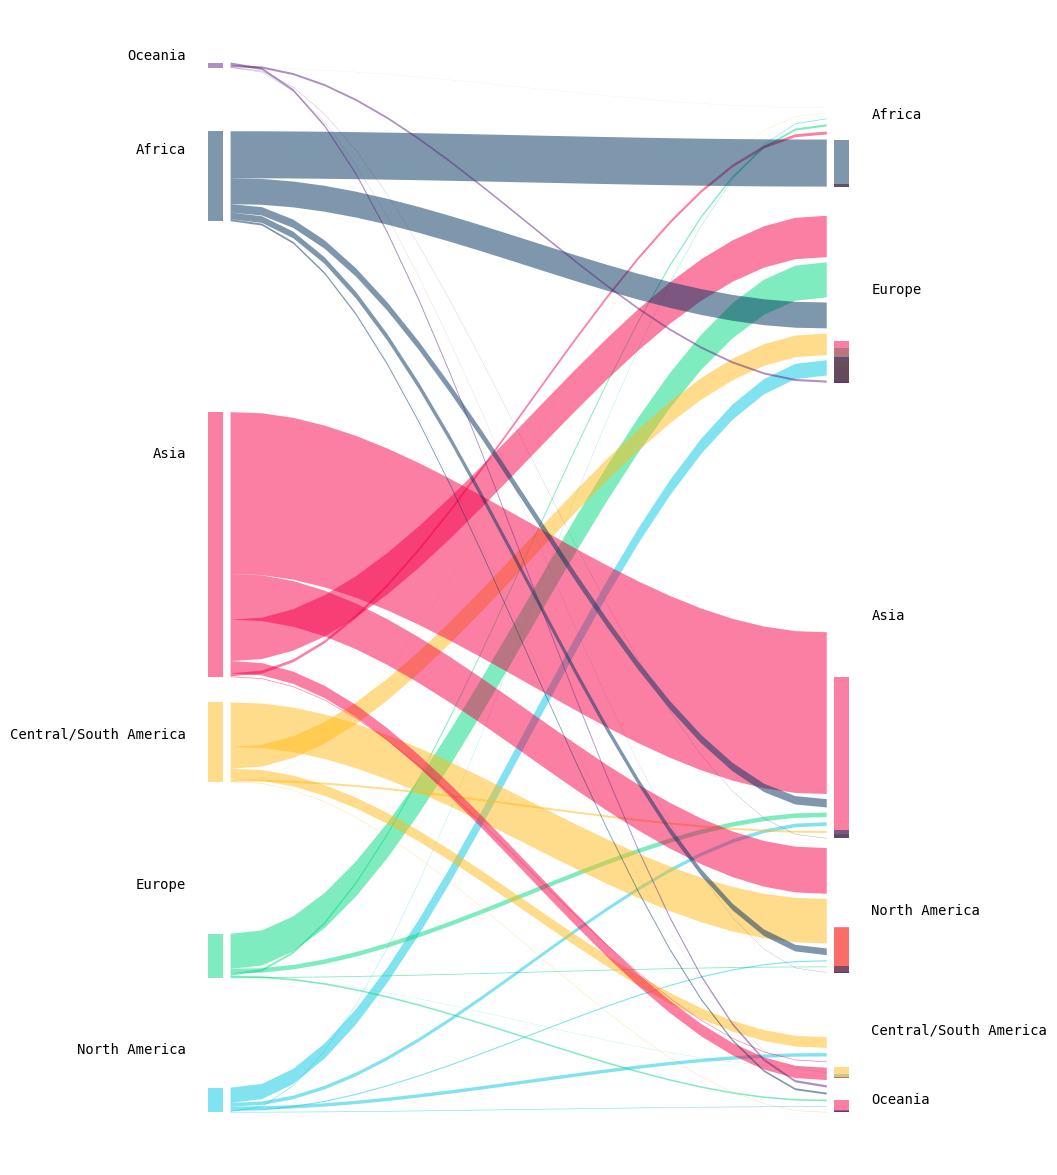

In [ ]:
######### Question 2 ##############


import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps

COLOR_MAPPING = {
    "North America": "#07C8E3",
    "Europe": "#00DA80",
    "Central/South America": "#FFBB18",
    "Asia": "#F60048",
    "Africa": "#00305D",
    "Oceania": "#5C2483"
}

def plot(input_data, *args, **kwargs):
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax

class AlluvialTool:
    def __init__(self, input_data=(), x_range=(0, 1), res=20, h_gap_frac=0.03, v_gap_frac=0.03, **kwargs):
        self.input = input_data
        self.x_range = x_range
        self.res = res
        self.h_gap_frac = h_gap_frac
        self.v_gap_frac = v_gap_frac
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(
            src_label_override=kwargs.get('src_label_override', None),
            dst_label_override=kwargs.get('dst_label_override', None)
        )
        self.h_gap = x_range[1] * h_gap_frac
        total_flow = sum(width for sub in self.input_data_dict.values() for width in sub.values())
        self.v_gap = total_flow * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.dst_flow_coords = self.assign_destination_flow_coords()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()


    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)
        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1]])
        y_new = np.concatenate([ty, ty[::-1] + width])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        return self.input

    def read_input(self):
        if isinstance(self.input, dict):
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()
        for src_item, dst_dict in self.input_data_dict.items():
            for dst_item, width in dst_dict.items():
                iwd[src_item] += width
                iwd[dst_item] += width
        return iwd

    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
        if src_label_override is not None:
            src_ordered_labels = src_label_override
        else:
            src_ordered_labels = sorted(self.input_data_dict.keys(), key=lambda x: self.item_width_dict[x])
        if dst_label_override is not None:
            dst_ordered_labels = dst_label_override
        else:
            dst_ordered_labels = sorted({dst for subdict in self.input_data_dict.values() for dst in subdict},
                                          key=lambda x: self.item_width_dict[x])
        return src_ordered_labels, dst_ordered_labels

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
          last_pos = (max(self.group_widths) - self.get_group_width(group)) / 2
          for item in group:
              width = self.item_width_dict[item]
              xy = (self.x_range[ind], last_pos)
              item_coord_dict[(ind, item)] = ItemCoordRecord()
              item_coord_dict[(ind, item)].set_start_state(width, xy, side=ind)
              last_pos += width + self.v_gap
        return item_coord_dict

    def generate_alluvial_vein(self, src_item, dst_item):
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[(0, src_item)].read_state_and_advance_y(width)
        dst_item_coord = self.dst_flow_coords[(src_item, dst_item)]
        y_range = (src_item_coord[1], dst_item_coord[1])
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (self.generate_item_sub_rectangle(a_item, width, side=0),
                self.generate_item_sub_rectangle(b_item, width, side=1))

    def generate_item_sub_rectangle(self, item, width, side=0):
        record = self.item_coord_dict[(side, item)]
        item_coord = record.read_state()
        sign = record.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)

    def generate_alluvial_fan(self):
        alluvial_fan = OrderedDict()
        for src_item in self.src_group:
            dst_items = self.input_data_dict[src_item].items()
            sorted_dst = sorted(dst_items, key=lambda x: x[1])
            for dst_item, width in sorted_dst:
                src_label_rect, dst_label_rect = self.get_label_rectangles_xy(src_item, dst_item)
                alluvial_fan[(src_item, dst_item)] = [
                    self.generate_alluvial_vein(src_item, dst_item),
                    src_label_rect,
                    dst_label_rect,
                ]
        return alluvial_fan

    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)
        sorted_connections = list(self.alluvial_fan.items())
        color_side = kwargs.get('color_side', 0)
        color_items = self.dst_group if color_side else self.src_group
        ind_dic = {item: ind for ind, item in enumerate(color_items)}
        for (src_item, dst_item), vein_items in sorted_connections:
            key = dst_item if color_side else src_item
            color = colors[ind_dic[key]]
            for patch_coords in vein_items:
                ax.add_patch(Polygon(patch_coords, facecolor=color, alpha=alpha))
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        ax.set_xlim(self.x_range[0] - 0.1, self.x_range[1] + 0.2)
        return ax

    def get_color_array(self, colors=None, color_side=0, **kwargs):
        color_items = self.dst_group if color_side else self.src_group
        color_array = [COLOR_MAPPING.get(item, "#CCCCCC") for item in color_items]
        return np.array(color_array)

    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        for side, group in enumerate(self.groups):
            for item in group:
                record = self.item_coord_dict[(side, item)]
                y_width = record.get_width()
                sign = record.get_side_sign()
                ha = 'left' if sign == 1 else 'right'
                offset = 1.5 * self.h_gap if sign == 1 else -1.5 * self.h_gap
                adjusted_y = self.dst_flow_coords.get((side, item), record.get_xy())[1]

                plt.text(
                    record.get_x() + offset,
                    adjusted_y + y_width / 2,
                    self.item_text(item, side, **kwargs),
                    ha=ha, va='center', fontname=fontname
                )


    def label_sides(self, labels=None, label_shift=0, disp_width=False, wdisp_sep='       ', fontname='Arial', **kwargs):
        if labels is not None:
            y = max(self.group_widths) / 2
            itl, wtl = self.item_text_len, self.width_text_len
            for side, sign in enumerate((-1, 1)):
                plt.text(
                    self.x_range[side] + sign * (label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl)) * self.h_gap_frac,
                    y,
                    labels[side],
                    ha='center', va='center', fontname=fontname, fontsize=13, rotation=90 - 180 * side
                )

    def item_text(self, item, side, disp_width=False, wdisp_sep='       ', width_in=True, **kwargs):
        return item


    def assign_destination_flow_coords(self):
        right_side_v_gap = self.v_gap * 0.5
        dst_flow_coords = {}
        for dst_item in self.dst_group:
            flows = []
            for src_item in self.src_group:
                if dst_item in self.input_data_dict[src_item]:
                    width = self.input_data_dict[src_item][dst_item]
                    flows.append((src_item, width))
            flows.sort(key=lambda x: x[1], reverse=False)
            if dst_item == "Africa":
                flows = list(reversed(flows))
            base_y = self.item_coord_dict[(1, dst_item)].xy[1]
            current_y = base_y
            for src_item, width in flows:
                dst_flow_coords[(src_item, dst_item)] = (self.x_range[1], current_y)
                current_y += width + right_side_v_gap
        return dst_flow_coords


class ItemCoordRecord:
    def __init__(self):
        self.width = 0
        self.xy = ()
        self.curr_xy = []
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(xy)
        self.side = side

    def read_state_and_advance_y(self, width):
        out = list(self.curr_xy)
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = list(self.curr_xy)
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return list(self.curr_xy)

    def get_xy(self):
        return self.xy

    def get_x(self):
        return self.xy[0]

    def get_y(self):
        return self.xy[1]

    def get_width(self):
        return self.width

    def get_side_sign(self):
        return 1 if self.side else -1

if __name__ == '__main__':
    import pandas as pd

    df = pd.read_csv('migration.csv')
    df.set_index('origin', inplace=True)
    input_data = df.to_dict(orient='index')

    src_order = ['North America', 'Europe', 'Central/South America', 'Asia', 'Africa', 'Oceania']
    dst_order = ['Oceania', 'Central/South America', 'North America', 'Asia', 'Europe', 'Africa']

    ax = plot(input_data,
              src_label_override=src_order,
              dst_label_override=dst_order,
              h_gap_frac=0.05,
              v_gap_frac=0.02)

    plt.show()

In [ ]:
'''
Attribute
AI to understand how the source code works.

'''